In [1]:
# 나눔 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

# matplotlib에 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 직접 등록 방법
fe = fm.FontEntry(
 fname=font_path,
 name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)

# 폰트 설정 적용
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 표시 문제 해결

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric-temporal




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [ ]:
# Google Drive 연결

from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: 

In [ ]:
#데이터 준비 및 그래프 구성

데이터 로드 및 전처리 중...
시간적 그래프 데이터셋 생성 중...
훈련 데이터셋 크기: 206
테스트 데이터셋 크기: 52
모델 훈련 시작...
에폭 5/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
에폭 10/50, 훈련 손실: 0.0055, 테스트 손실: 0.0056
에폭 15/50, 훈련 손실: 0.0054, 테스트 손실: 0.0057
에폭 20/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
에폭 25/50, 훈련 손실: 0.0054, 테스트 손실: 0.0059
에폭 30/50, 훈련 손실: 0.0054, 테스트 손실: 0.0056
에폭 35/50, 훈련 손실: 0.0054, 테스트 손실: 0.0060
에폭 40/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
에폭 45/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
에폭 50/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
GNN 점수 추출 중...
원본 데이터와 GNN 점수 병합 중...
원본 데이터와 GNN 점수가 'combined_data_with_gnn_scores.csv'에 저장되었습니다.
GNN 점수와 rebalance_priority 간 상관관계: 0.5794
모든 처리가 완료되었습니다.


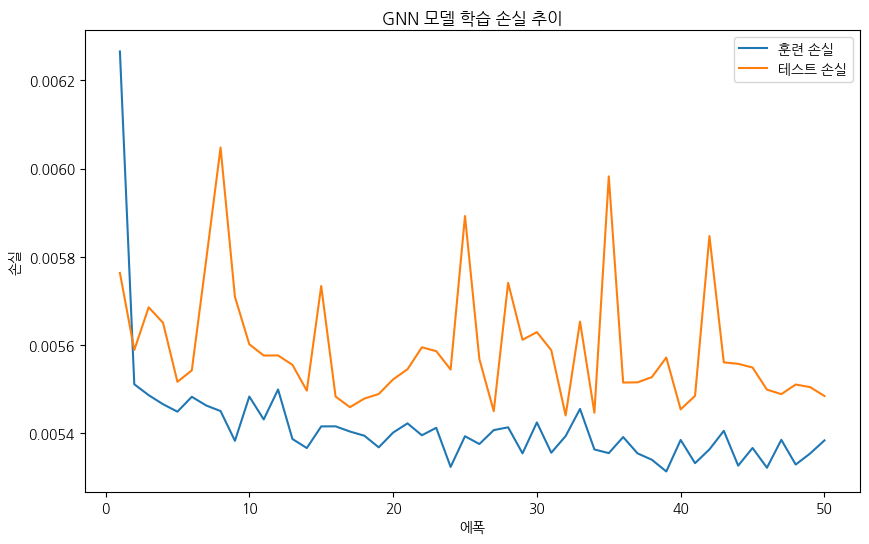

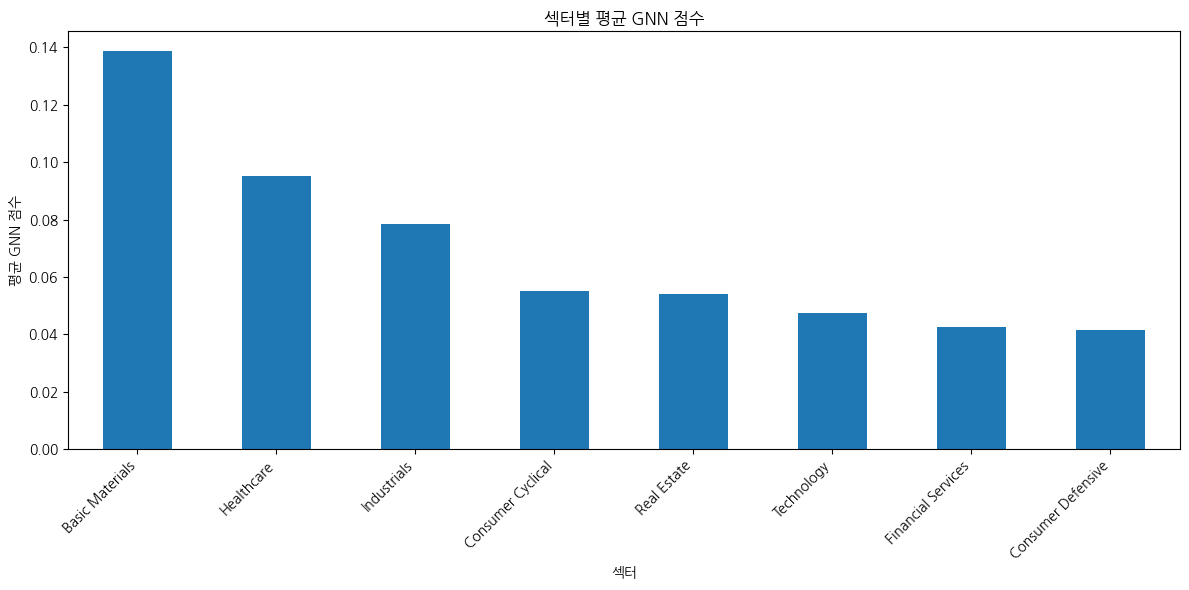

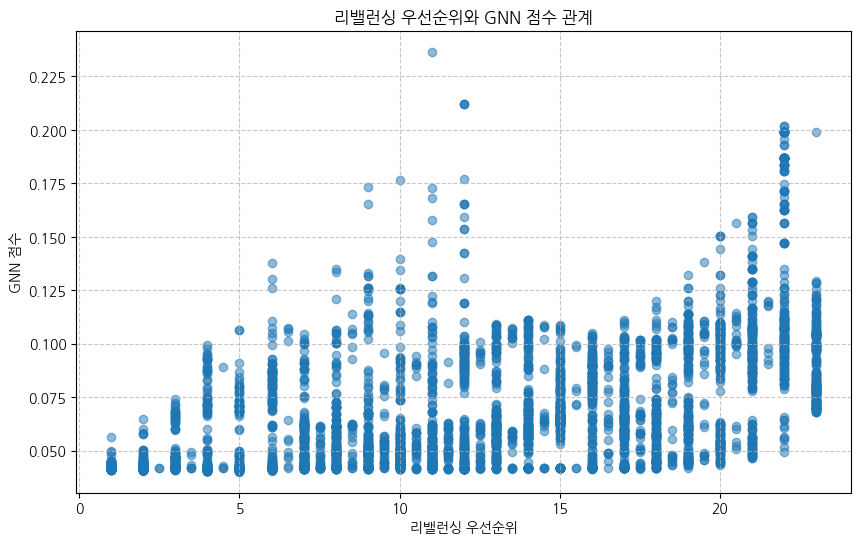

In [2]:
# 필요한 라이브러리 임포트
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Dropout

# CSV 파일 로드
def load_data(file_path):
    """
    CSV 파일에서 데이터를 로드하고 필요한 정보를 추출합니다.
    """
    df = pd.read_csv(file_path)

    # 날짜 목록 추출
    dates = df['Date'].unique()
    dates.sort()  # 날짜순 정렬

    # 종목 목록 추출
    symbols = df['Symbol'].unique()
    symbol_to_idx = {symbol: idx for idx, symbol in enumerate(symbols)}

    # 5-Factor 특성 추출
    factor_cols = ['Beta_Factor', 'Value_Factor', 'Size_Factor', 'Momentum_Factor', 'Volatility_Factor']

    return df, dates, symbols, symbol_to_idx, factor_cols

# 커스텀 데이터셋 분할 함수 정의
def temporal_signal_split_custom(temporal_dataset, train_ratio=0.8):
    """
    시간적 그래프 데이터셋을 훈련 및 테스트 세트로 분할하는 함수
    """
    train_snapshots = int(train_ratio * len(temporal_dataset))

    train_dataset = temporal_dataset[:train_snapshots]
    test_dataset = temporal_dataset[train_snapshots:]

    return train_dataset, test_dataset

# 시간적 그래프 데이터셋 생성 함수
def create_temporal_graph_dataset(df, dates, symbols, symbol_to_idx, factor_cols):
    """
    날짜별 그래프 스냅샷을 생성하는 함수
    """
    temporal_dataset = []

    for date_idx, date in enumerate(dates):
        date_df = df[df['Date'] == date]

        # 각 종목의 5-Factor 특성 추출
        node_features = np.zeros((len(symbols), len(factor_cols)))
        for _, row in date_df.iterrows():
            if row['Symbol'] in symbol_to_idx:
                idx = symbol_to_idx[row['Symbol']]
                node_features[idx] = [row[col] for col in factor_cols]

        # 결측값을 0으로 채움
        node_features = np.nan_to_num(node_features, nan=0.0)

        # 상관관계 기반 엣지 생성
        edge_index = []
        edge_attr = []

        # 상관관계 임계값 (조정 가능)
        threshold = 0.3

        # 엣지 생성 (상관관계 기반)
        if date_idx > 0:  # 첫 날은 이전 데이터가 없어 상관관계 계산 불가
            prev_date = dates[date_idx-1]
            prev_date_df = df[df['Date'] == prev_date]

            # 섹터 정보 사용
            sectors = {}
            for _, row in date_df.iterrows():
                if row['Symbol'] in symbol_to_idx:
                    sectors[symbol_to_idx[row['Symbol']]] = row.get('Sector', 'Unknown')

            # 모멘텀 상관관계 계산
            for i in range(len(symbols)):
                for j in range(len(symbols)):
                    if i != j:
                        # 섹터가 같은 종목들은 연결
                        if i in sectors and j in sectors and sectors[i] == sectors[j]:
                            edge_index.append([i, j])

                            # 모멘텀 기반 가중치 추가
                            mom_i = node_features[i][3]  # Momentum_Factor
                            mom_j = node_features[j][3]  # Momentum_Factor

                            # 모멘텀 상관관계를 엣지 속성으로
                            correlation = max(0.1, 1 - abs(mom_i - mom_j))
                            edge_attr.append([correlation])

        # 엣지 정보 변환
        if len(edge_index) > 0:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            # edge_attr이 1차원인 경우 2차원으로 변환
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
        else:
            # 엣지가 없는 경우 더미 엣지 생성
            edge_index = torch.zeros((2, 1), dtype=torch.long)
            edge_attr = torch.ones((1, 1), dtype=torch.float)  # 2차원 텐서로 생성

        # 노드 특성 및 타겟 값
        x = torch.tensor(node_features, dtype=torch.float)

        # 목표값: rebalance_priority와 to_rebalance 기반
        y = np.zeros(len(symbols))
        for _, row in date_df.iterrows():
            if row['Symbol'] in symbol_to_idx:
                idx = symbol_to_idx[row['Symbol']]
                # to_rebalance가 1이면 리밸런싱 필요, 우선순위는 rebalance_priority
                if 'to_rebalance' in row and 'rebalance_priority' in row:
                    if row['to_rebalance'] == 1:
                        y[idx] = row['rebalance_priority'] / 100.0  # 정규화
                    else:
                        y[idx] = 0.0

        y = torch.tensor(y, dtype=torch.float)

        # 그래프 데이터 객체 생성
        snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        temporal_dataset.append(snapshot)

    return temporal_dataset

# A3TGCN 기반 TGNN 모델 정의
class TemporalGNN(torch.nn.Module):
    """
    시간적 그래프 신경망 모델 정의
    """
    def __init__(self, node_features, hidden_channels=32):
        super(TemporalGNN, self).__init__()
        # GCN 레이어
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # 출력 레이어
        self.linear = Linear(hidden_channels, 1)

        # 드롭아웃 - 과적합 방지
        self.dropout = Dropout(0.2)

    def forward(self, x, edge_index, edge_attr=None):
        # edge_attr 안전 처리
        if edge_attr is None:
            edge_weight = None
        else:
            # edge_attr의 차원에 따라 처리
            if edge_attr.dim() == 0:
                edge_weight = None
            elif edge_attr.dim() == 1:
                edge_weight = edge_attr
            else:
                edge_weight = edge_attr.view(-1) if edge_attr.numel() > 0 else None

        # 첫 번째 레이어
        h = self.conv1(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.dropout(h)

        # 두 번째 레이어
        h = self.conv2(h, edge_index, edge_weight)
        h = F.relu(h)

        # 노드 임베딩 (DDPG에 전달할 값)
        embeddings = h

        # 출력 레이어 (훈련용)
        predictions = self.linear(h).squeeze()

        return embeddings, predictions

# 모델 훈련 함수
def train_model(model, train_dataset, test_dataset, epochs=50):
    """
    GNN 모델 훈련 함수
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for snapshot in train_dataset:
            optimizer.zero_grad()

            # edge_attr 안전 처리
            edge_attr = snapshot.edge_attr
            if edge_attr is not None and edge_attr.dim() == 0:
                edge_attr = edge_attr.unsqueeze(0).unsqueeze(0)
            elif edge_attr is not None and edge_attr.dim() == 1:
                edge_attr = edge_attr.unsqueeze(1)

            # 모델 순전파
            embeddings, predictions = model(snapshot.x, snapshot.edge_index, edge_attr)

            # 손실 계산
            loss = criterion(predictions, snapshot.y)

            # 역전파 및 가중치 업데이트
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataset)
        train_losses.append(avg_train_loss)

        # 테스트
        model.eval()
        total_loss = 0

        with torch.no_grad():
            for snapshot in test_dataset:
                # edge_attr 안전 처리
                edge_attr = snapshot.edge_attr
                if edge_attr is not None and edge_attr.dim() == 0:
                    edge_attr = edge_attr.unsqueeze(0).unsqueeze(0)
                elif edge_attr is not None and edge_attr.dim() == 1:
                    edge_attr = edge_attr.unsqueeze(1)

                embeddings, predictions = model(snapshot.x, snapshot.edge_index, edge_attr)

                loss = criterion(predictions, snapshot.y)
                total_loss += loss.item()

        avg_test_loss = total_loss / len(test_dataset)
        test_losses.append(avg_test_loss)

        if (epoch + 1) % 5 == 0:
            print(f"에폭 {epoch+1}/{epochs}, 훈련 손실: {avg_train_loss:.4f}, 테스트 손실: {avg_test_loss:.4f}")

    return train_losses, test_losses

# GNN 임베딩 및 점수 추출 함수 (날짜별 점수 추출)
def extract_gnn_scores(model, dataset, symbols, dates):
    """
    훈련된 GNN 모델을 사용하여 각 날짜별 종목의 GNN 점수를 추출합니다.
    """
    model.eval()
    all_scores_dfs = []
    all_embeddings = []

    with torch.no_grad():
        for i, snapshot in enumerate(dataset):
            # edge_attr 안전 처리
            edge_attr = snapshot.edge_attr
            if edge_attr is not None and edge_attr.dim() == 0:
                edge_attr = edge_attr.unsqueeze(0).unsqueeze(0)
            elif edge_attr is not None and edge_attr.dim() == 1:
                edge_attr = edge_attr.unsqueeze(1)

            # 현재 날짜
            current_date = dates[i]

            # 모델로 예측
            embeddings, predictions = model(snapshot.x, snapshot.edge_index, edge_attr)
            all_embeddings.append(embeddings)

            # 현재 날짜에 대한 점수 데이터프레임 생성
            date_scores_df = pd.DataFrame({
                'Symbol': symbols,
                'Date': current_date,
                'gnn_scores': predictions.numpy()
            })

            all_scores_dfs.append(date_scores_df)

    # 모든 날짜의 점수를 하나의 데이터프레임으로 합침
    scores_df = pd.concat(all_scores_dfs, ignore_index=True)

    return scores_df, all_embeddings

# 메인 함수
def main(file_path="processed_5factor_model.csv"):
    """
    메인 실행 함수 - 데이터 로드, 모델 훈련, 점수 추출 및 결과 저장
    """
    # 데이터 로드 및 전처리
    print("데이터 로드 및 전처리 중...")
    df, dates, symbols, symbol_to_idx, factor_cols = load_data(file_path)

    # 시간적 그래프 데이터셋 생성
    print("시간적 그래프 데이터셋 생성 중...")
    temporal_dataset = create_temporal_graph_dataset(df, dates, symbols, symbol_to_idx, factor_cols)

    # 훈련 및 테스트 데이터셋 분할
    train_dataset, test_dataset = temporal_signal_split_custom(temporal_dataset, train_ratio=0.8)

    print(f"훈련 데이터셋 크기: {len(train_dataset)}")
    print(f"테스트 데이터셋 크기: {len(test_dataset)}")

    # 모델 초기화
    node_features = temporal_dataset[0].x.shape[1]
    model = TemporalGNN(node_features=node_features)

    # 모델 훈련
    print("모델 훈련 시작...")
    train_losses, test_losses = train_model(model, train_dataset, test_dataset, epochs=50)

    # GNN 점수 추출 (날짜 정보 포함)
    print("GNN 점수 추출 중...")
    scores_df, embeddings = extract_gnn_scores(model, temporal_dataset, symbols, dates)

    # 원본 데이터와 GNN 점수 병합 - Symbol과 Date 기준으로 병합
    print("원본 데이터와 GNN 점수 병합 중...")
    combined_df = df.merge(scores_df, on=['Symbol', 'Date'], how='left')

    # 결과 저장
    output_file = 'combined_data_with_gnn_scores.csv'
    combined_df.to_csv(output_file, index=False)
    print(f"원본 데이터와 GNN 점수가 '{output_file}'에 저장되었습니다.")

    # 학습 손실 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='훈련 손실')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='테스트 손실')
    plt.xlabel('에폭')
    plt.ylabel('손실')
    plt.title('GNN 모델 학습 손실 추이')
    plt.legend()
    plt.savefig('training_loss.png')

    return model, combined_df, embeddings

# 모델 결과 평가 및 시각화 함수
def evaluate_model_results(combined_df):
    """
    모델 결과 평가 및 시각화
    """
    # GNN 점수와 rebalance_priority 간 상관관계 계산
    correlation = combined_df[['gnn_scores', 'rebalance_priority']].corr().iloc[0, 1]
    print(f"GNN 점수와 rebalance_priority 간 상관관계: {correlation:.4f}")

    # 섹터별 평균 GNN 점수 계산
    sector_avg = combined_df.groupby('Sector')['gnn_scores'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sector_avg.plot(kind='bar')
    plt.title('섹터별 평균 GNN 점수')
    plt.ylabel('평균 GNN 점수')
    plt.xlabel('섹터')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('sector_gnn_scores.png')

    # 리밸런싱 우선순위와 GNN 점수 산점도
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_df['rebalance_priority'], combined_df['gnn_scores'], alpha=0.5)
    plt.xlabel('리밸런싱 우선순위')
    plt.ylabel('GNN 점수')
    plt.title('리밸런싱 우선순위와 GNN 점수 관계')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('rebalance_vs_gnn.png')

# 메인 실행 코드
if __name__ == "__main__":
    # 파일 경로 설정 - 사용자 환경에 맞게 변경
    file_path = "/content/sample_data/processed_daily_5factor_model_20250525.csv"

    # 메인 함수 실행
    model, combined_df, embeddings = main(file_path)

    # 결과 평가 및 시각화
    evaluate_model_results(combined_df)

    print("모든 처리가 완료되었습니다.")
